4.6 Dropout

4.6.4 Implementation from Scratch

In [ ]:
!pip install d2l==0.14.2
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
  assert 0<=dropout<=1
  # In this case, all elements are dropped out
  if dropout == 1:
    return torch.zeros_like(X)
  # In this case, all elements are kept
  if dropout == 0:
    return X
  mask = (torch.rand(X.shape) > dropout).float()
  return mask*X / (1.0 - dropout)

In [ ]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  0., 10.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [ ]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
  def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
               is_training = True):
    super(Net, self).__init__()
    self.num_inputs = num_inputs
    self.training = is_training
    self.lin1 = nn.Linear(num_inputs, num_hiddens1)
    self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
    self.lin3 = nn.Linear(num_hiddens2, num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):
    H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
    # Use dropout only when training the model
    if self.training == True:
      # Add a dropout layer after the first fully connected layer
      H1 = dropout_layer(H1, dropout1)
    H2 = self.relu(self.lin2(H1))
    if self.training == True:
      # Add a dropout layer after the second fully connected layer
      H2 = dropout_layer(H2, dropout2)
    out = self.lin3(H2)
    return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

4.6.5 Concise Implementation

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the first fully connected layer
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the second fully connected layer
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

4.8 Numerical Stability and Initialization

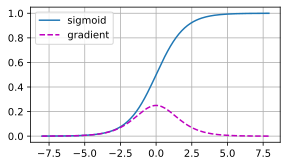

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [ ]:
M=torch.normal(0, 1, size=(4,4))
print('a single matrix \n', M)
for i in range(100):
  M = torch.mm(M, torch.normal(0, 1, size=(4,4)))

print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-0.8896, -0.2391, -0.4638,  1.0587],
        [ 0.2154, -0.6945,  0.1799,  1.4047],
        [ 0.3323,  0.7228,  1.5619, -0.0417],
        [-0.3356, -0.5452, -0.2324, -1.2466]])
after multiplying 100 matrices
 tensor([[-2.5145e+23,  5.8921e+23,  6.0777e+23, -1.3337e+24],
        [-3.3576e+23,  7.8676e+23,  8.1154e+23, -1.7808e+24],
        [ 2.4228e+23, -5.6773e+23, -5.8561e+23,  1.2851e+24],
        [ 4.8479e+22, -1.1360e+23, -1.1718e+23,  2.5713e+23]])


4.9 Environment and Distribution Shift

4.10 Predicting House Prices on Kaggle

In [ ]:
import hashlib
import os
import torch
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):
  """Download a file inserted into DATA_HUB, return the local filename."""
  assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exit_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
      if sha1.hexdigest() == sha1_hash:
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
      f.write(r.content)
    return name

In [ ]:
def download_extract(name, folder=None):
  """Download and extract a zip/tar file."""
  fname=download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False, 'Only zip/tar files can be extracted.'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data

def download_all():
  """Download all files in the DATA_HUB."""
  for name in DATA_HUB:
    download(name)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
DATA_HUB['kaggle_house_train']=(
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test']=(
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [ ]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [ ]:
# 'Dummy_na=True' considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features,1))
  return net

In [ ]:
def log_rmse(net, features, labels):
  # To further stabilize the value when the logarithm is taken, set the
  # value less than 1 as 1
  clipped_preds = torch.clamp(net(features), 1, float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_preds),
                         torch.log(labels)))
  
  return rmse.item()

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls=[]. []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # The Adam optimization algorithm is used here
  optimizer = torch.optim.Adam(net.parameters(),
                               lr=learning_rate,
                               weight_decay = weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

In [ ]:
def get_k_fold_data(k, i, X, y):
  assert k>1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j*fold_size, (j+1)*fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j==i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                               weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i ==0:
      d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
               xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
               legend = ['train', 'valid'], yscale='log')
    print(f'fold{i+1}, train log rmse {float(train_ls[-1]):f},'
          f'valid log rmse {float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
  net = get_net()
  train_ls, _ = train(net, train_features, train_labels, None, None,
                      num_epochs, lr, weight_decay, batch_size)
  d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch',
           ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
  print(f'train_log rmse {float(train_ls[-1]):f}')
  # Apply the network to the test set
  preds = net(test_features).detach().numpy()
  # Reformat it to export to Kaggle
  test_data['SalePrice']=pd.Series(preds.reshape(1, -1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
  submission.to_csv('submission.csv', index=False)

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)